In [122]:
import glob
import mdtraj as md
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
pdbfiles = glob.glob('eth-*/*.pdb')
trajfiles = glob.glob('eth-*/*.nc')
trajfiles.sort()

In [180]:
def getPopulationData(traj, pdb):
    # Load the trajectory and compute the atom distances
    traj = md.load(traj, top=pdb)
    dist = md.compute_distances(traj, [[0,2]])
    state_list = [0 if i <=0.49 else 1 for i in dist]
    counts = (state_list.count(0), state_list.count(1))
    
    # Create a list of the populations over time
    states_over_time = []
    stateA = 0
    stateB = 0
    for idx,state in enumerate(state_list):
        if state==0:
            stateA+=1
        elif state==1:
            stateB+=1

        states_over_time.append([stateA/(idx+1), stateB/(idx+1)])
    states_over_time = np.vstack(states_over_time)
    
    # Create a list which counts the transitions over time
    transitions_over_time = [0]
    transitions = 0
    try:
        # Loop over states and count transitions
        for i,state in enumerate(state_list):
            if state != state_list[i+1]:
                transitions+=1
            transitions_over_time.append(transitions)
    except Exception as e:
        #Ignore excpetion for last frame
        pass

    
    # Calculate the error stderr = sigma/sqrt(Neff)
    # Sigma = stddev of population of each state
    # Neff = number of transitions
    data = []
    for idx, states in enumerate(states_over_time):
        stderrA = np.std(states_over_time[:idx,0])/np.sqrt(transitions_over_time[idx])
        stderrB = np.std(states_over_time[:idx,1])/np.sqrt(transitions_over_time[idx])
        data.append([states[0], states[1], stderrA, stderrB])
    data = np.vstack(data)
    return data

In [189]:
def plotPopulations(data, title):
    plt.figure(figsize=(16,9))
    plt.subplot(211)
    plt.errorbar(range(len(data[:,0])), data[:,0], yerr=3*data[:,2], color='blue', ecolor='black', linewidth=2)
    plt.axhline(0.25, color='black', linestyle='--', linewidth=3)
    plt.errorbar(range(len(data[:,1])), data[:,1], yerr=3*data[:,3], color='orange', ecolor='black', linewidth=2)
    plt.axhline(0.75, color='black', linestyle='--', linewidth=3)
    plt.title(title)
    plt.legend(['{:.2f} {:.2f}'.format(data[-1,0],data[-1,1])])
    plt.autoscale(tight='both')
    plt.show()

/home/nathanlim/anaconda3/envs/molssi/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/nathanlim/anaconda3/envs/molssi/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/nathanlim/anaconda3/envs/molssi/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nathanlim/anaconda3/envs/molssi/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/nathanlim/anaconda3/envs/molssi/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in double_scalars


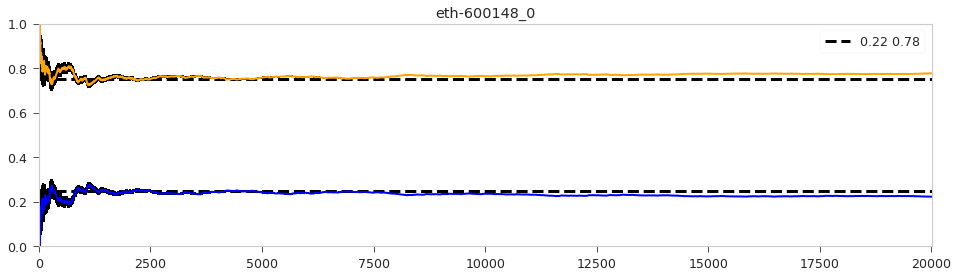

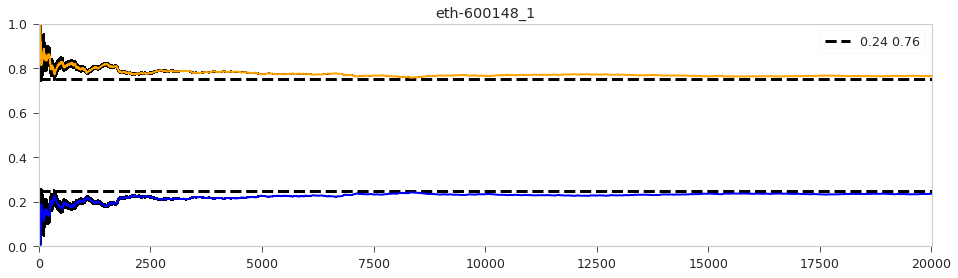

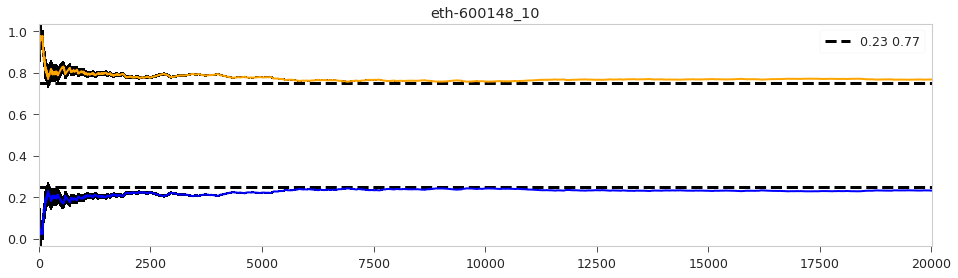

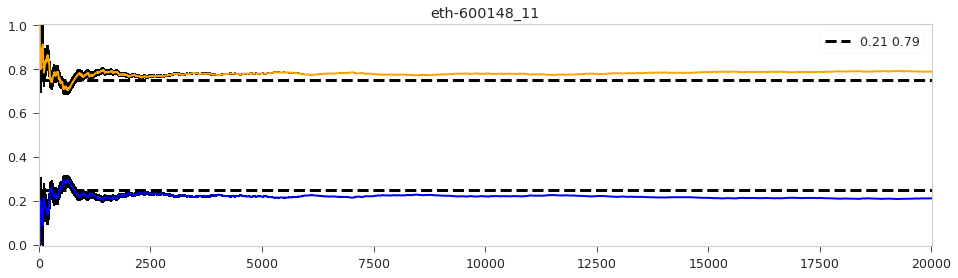

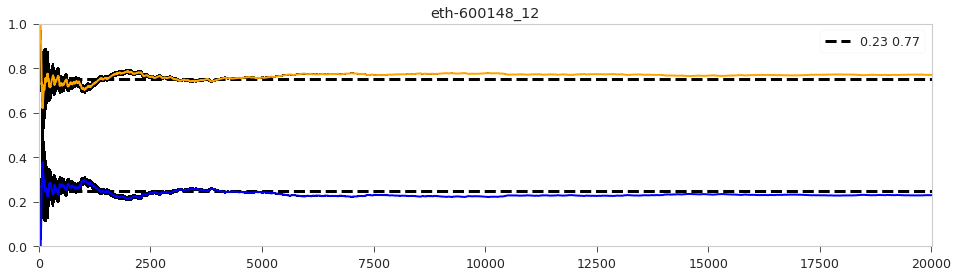

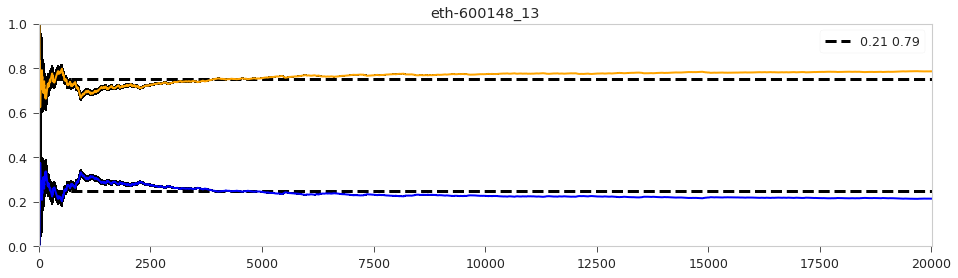

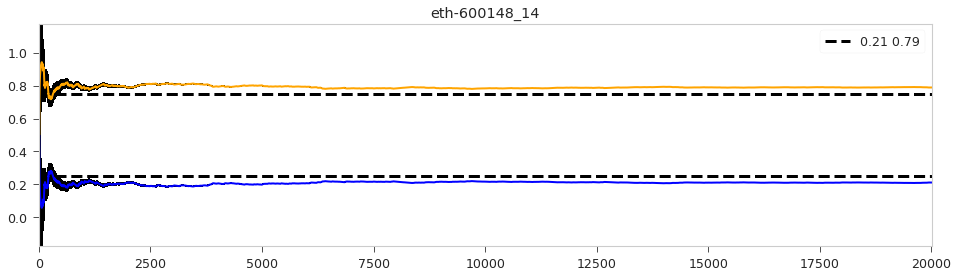

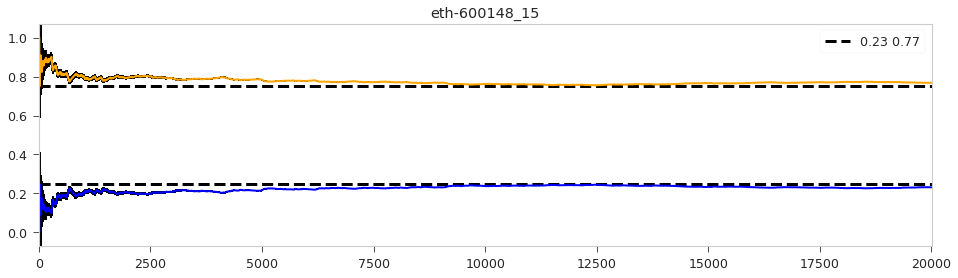

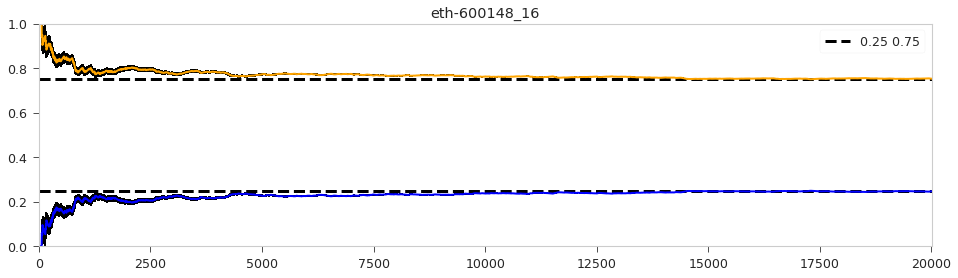

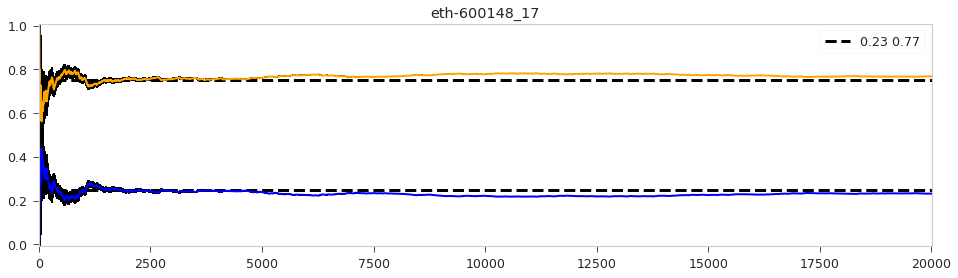

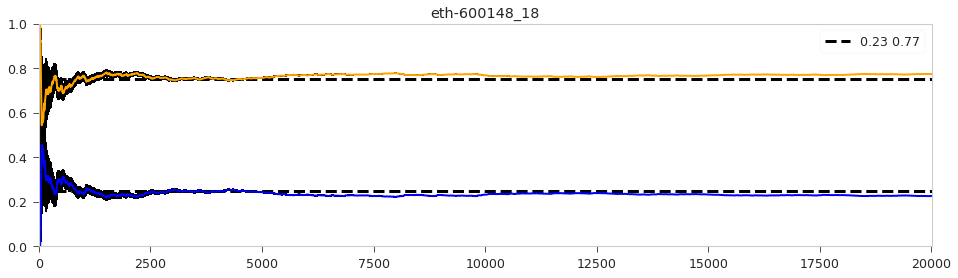

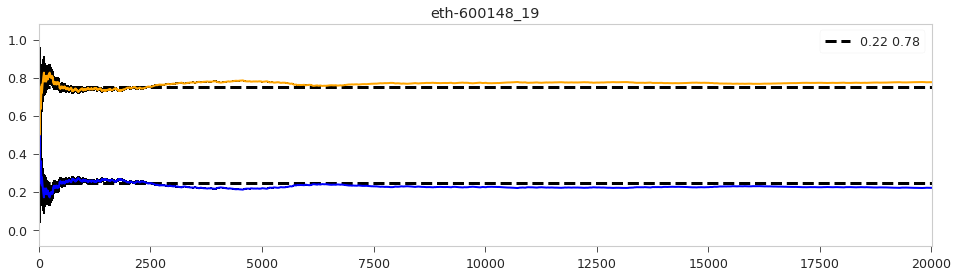

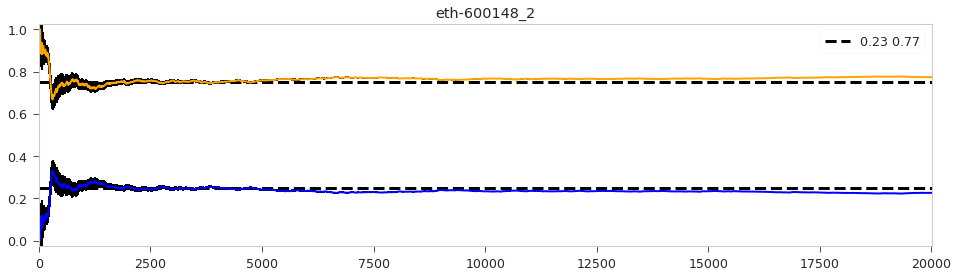

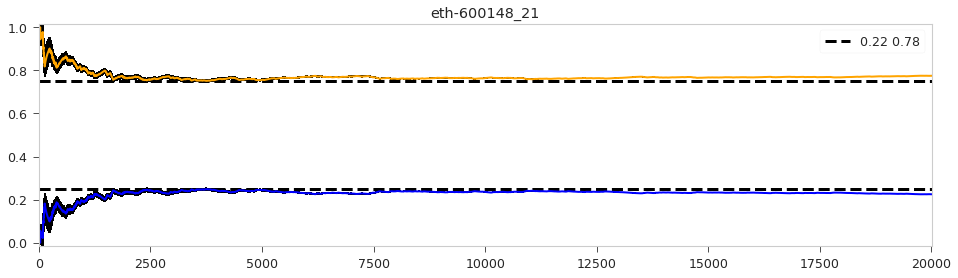

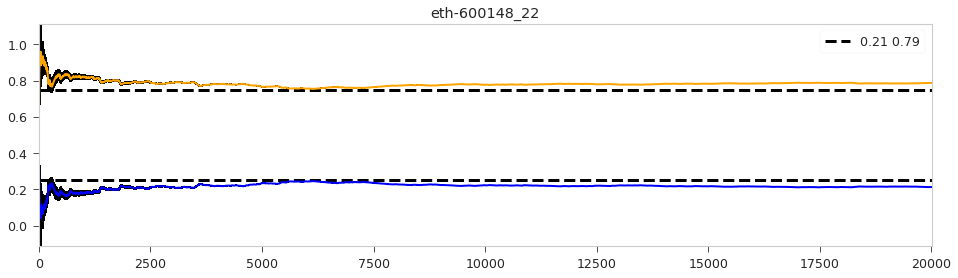

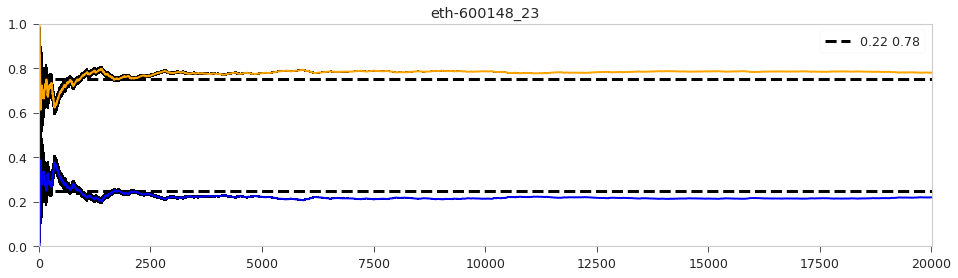

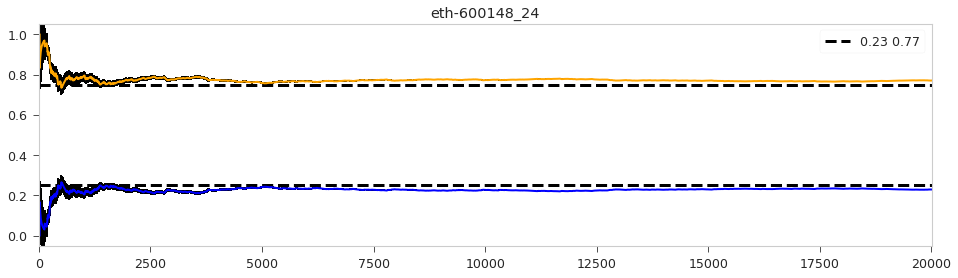

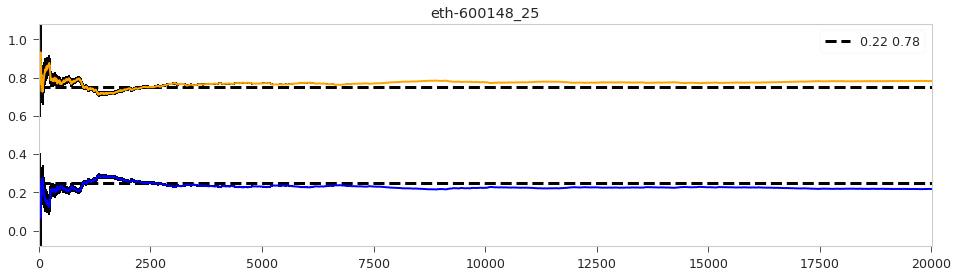

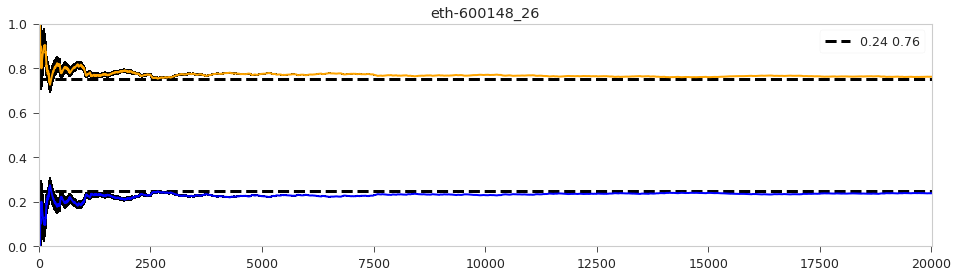

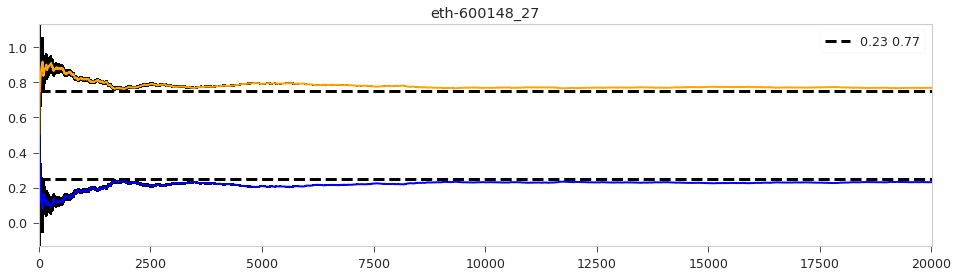

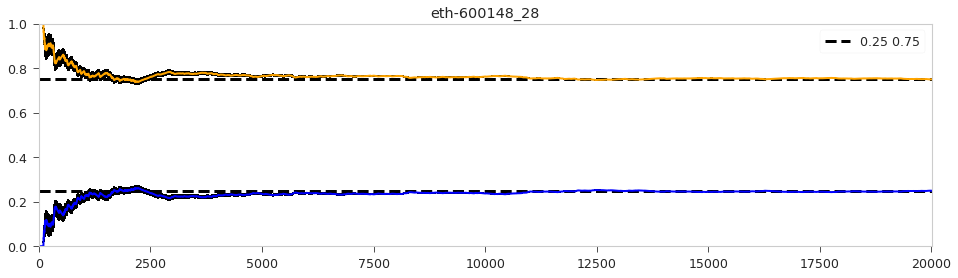

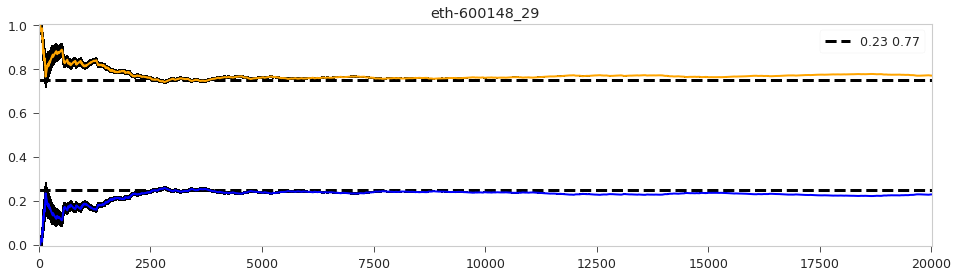

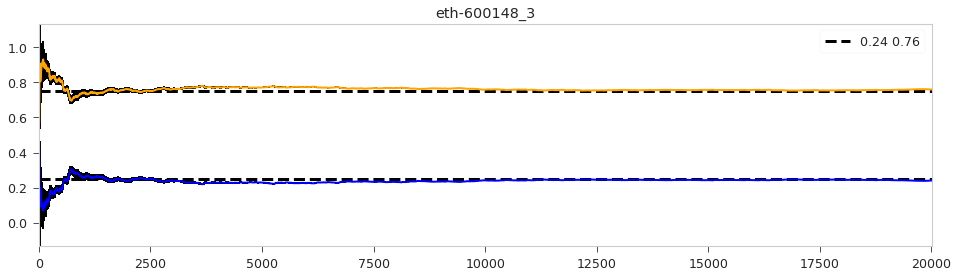

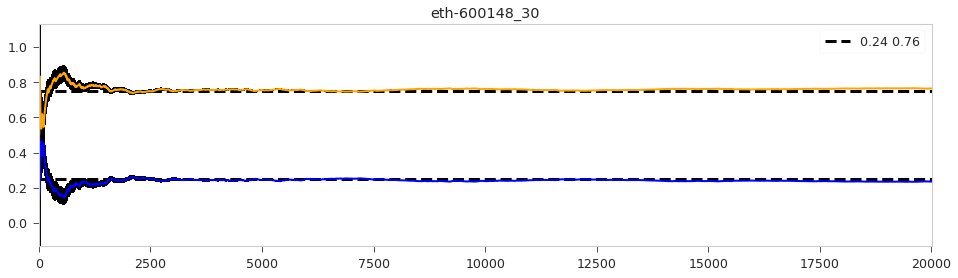

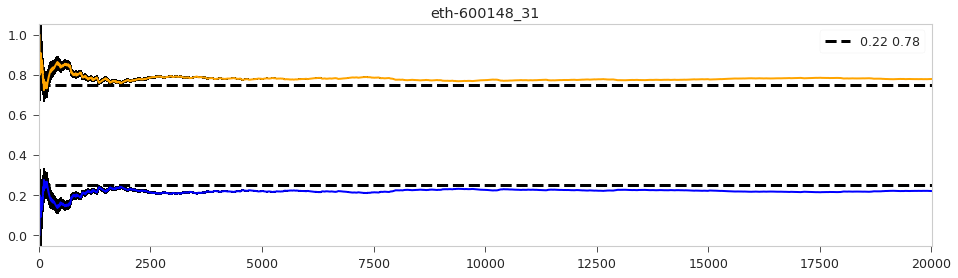

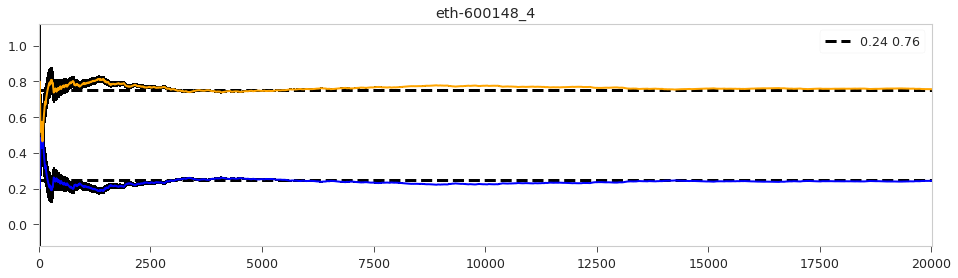

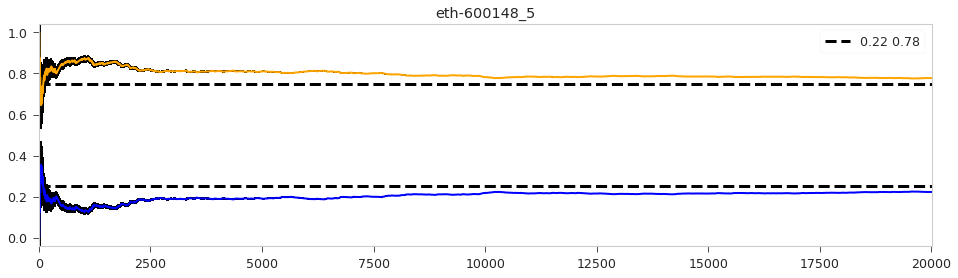

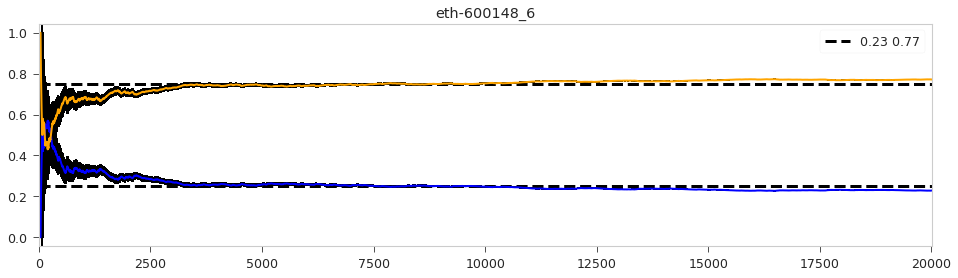

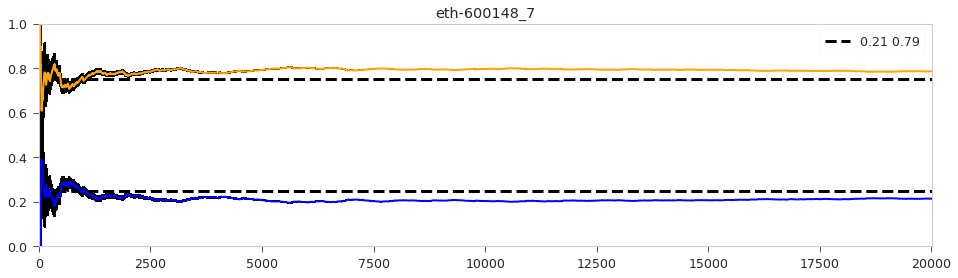

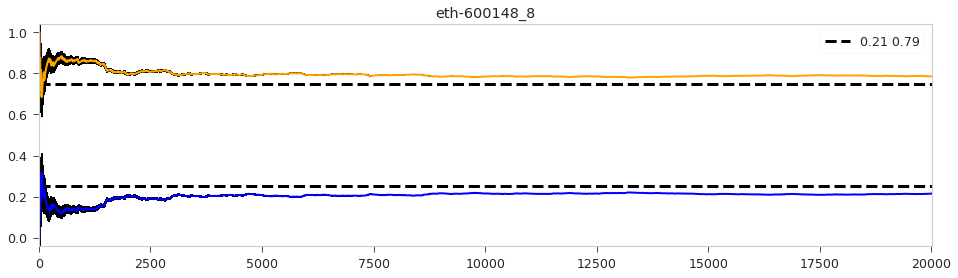

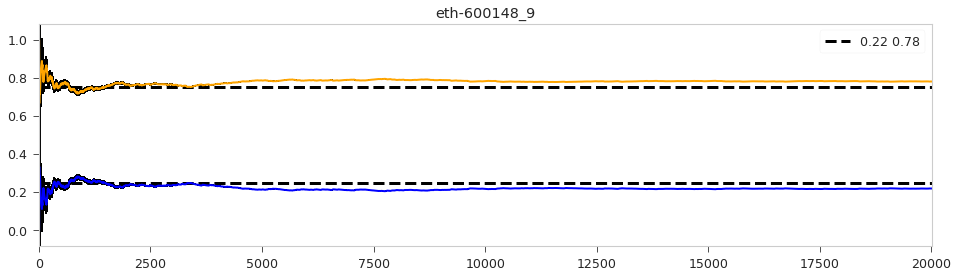

In [191]:
for traj,pdb in zip(trajfiles, pdbfiles):
    jobid = traj.split('/')[-1].strip('.nc')
    data = getPopulationData(traj,pdb)
    plotPopulations(data, jobid)
    